# Day 3: Machine Learning

In [1]:
# importing needed libraries globally
from PIL import Image # for reading images
import numpy as np # for arrays manipulations
import matplotlib.pyplot as plt # for 2D plottings
from skimage import color
from scipy import ndimage

def red(im):
    """
    Receive multi channels of an image and return the red channel
    """
    return im[:,:,0]
def green(im):
    """
    Receive multi channels of an image and return the green channel
    """
    return im[:,:,1]
def blue(im):
    """
    Receive multi channels of an image and return the blue channel
    """
    return im[:,:,2]

def gray(im):
    """
    Receive multi channels of an image and return a gray
    """
    return color.rgb2gray(im)
def imread(imgfile,numpy=False):
    """
    read an image as numpy array and make it mutatable
    """
    img = Image.open(imgfile)
    if numpy:
        img = np.asarray(img)
        return img.copy()
    else:
        return img

def blur(im,sigma=3):
    """
    return a blurred image
    """
    return ndimage.gaussian_filter(im,sigma)

def plot_grid(imarrays,titles,figsize=(10,10)):
    """
    show four images
    """
    count = 1
    plt.figure(figsize=figsize)
    for im,t in zip(imarrays,titles):
        plt.subplot(220+count)
        ax = plt.gca()
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator()) 
        count += 1
        if len(im.shape) < 3:
            plt.imshow(im,cmap="gray")
        else:
            plt.imshow(im)
        plt.title(t, size=20)
    plt.gcf().set_tight_layout(True)
    plt.show()

def normalize_img(s):
    """
    Receive image in any data types and range and normalize it
    to [0,255]
    """
    start = 0
    end = 255
    width = end - start
    res = (s - s.min())/(s.max() - s.min()) * width + start
    return res

def plot_hough_lines(img,hough,lines,theta,d):
    """
    Receive image, lines and hough space and plot them next to each other
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()
    # Image
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    # hough space
    ax[1].imshow(space,
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap="gray", aspect=1/1.5)

    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(img, cmap="gray")
    for x0,y0,x1,y1 in lines:
        ax[2].plot((x0,x1), (y0, y1), '-r')
    
    ax[2].set_xlim((0, img.shape[1]))
    ax[2].set_ylim((img.shape[0],0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()


## Parametric model

- A parametric model can represent a class of instances where each is defined by a value of the parameters
- Examples include lines, or circles, or even a parameterized template

### Fitting a parametric model
- Choose a parametric model to represent a set of features
- Membership criterion is not local
    - can't tell whether a point in the image belongs to a given model just by looking at that point
- Computational complexity is important
    - not feasible to examine possible parameter setting


### Example: Line fitting using Hough Transform

In [3]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

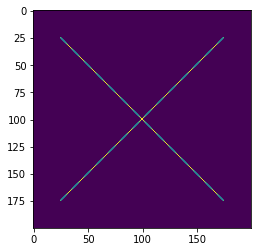

In [4]:
# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
plt.imshow(image)

In [237]:
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
def find_hough_lines(img,theta_range=[-np.pi / 2, np.pi / 2],num=360,top=10):
    """
    Receive an image and returns lines and the hough space detected using hough transform 
    """
    tested_angles = np.linspace(theta_range[0],theta_range[1], num)
    h, theta, d = hough_line(img, theta=tested_angles)
    origin = np.array((0, img.shape[1]))
    lines = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        lines.append((origin[0],y0,origin[1],y1))
    return lines[:top],np.log(1 + h),theta[:top],d[:top]

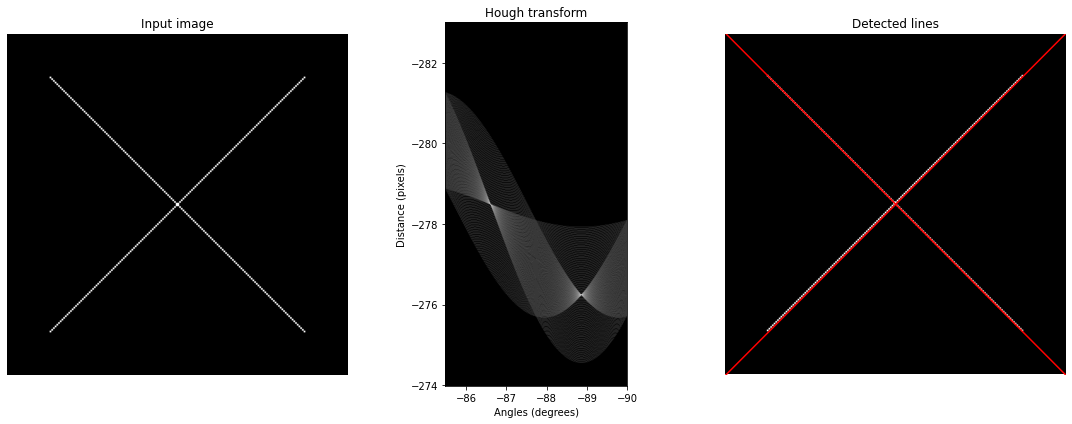

In [238]:
# Find hough lines
lines,space,theta,d = find_hough_lines(image)
# Plot 
plot_hough_lines(image,space,lines,theta,d)

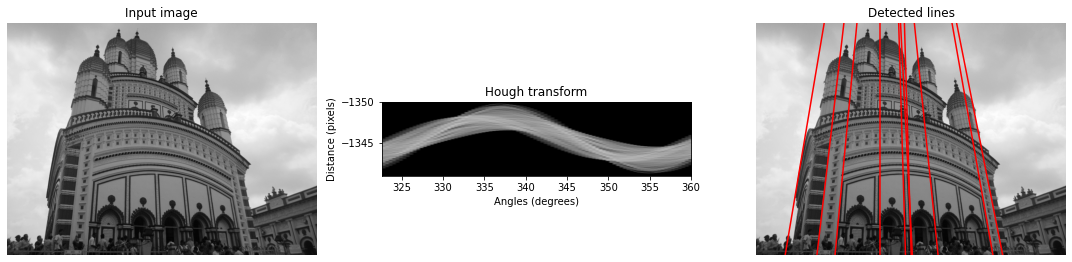

In [239]:
temple = gray(imread("imgs/temple.JPG",True))
# Find hough lines
edges = canny(temple,4)
lines,space,theta,d = find_hough_lines(edges,[np.deg2rad(360),np.deg2rad(-10)],90,top=10)
# Plot 
plot_hough_lines(temple,space,lines,theta,d)

### Example: Circle fitting

In [240]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
def find_hough_circle(img,hough_radii,top=4):
    """
    Receive image, radius search speace, how many to return
    Calculate canny edge, apply find hough circle
    Return centers and radii of the @top found circles
    """
    edges = canny(gray(img), sigma=3)
    # Detect two radii
    hough_res = hough_circle(edges, hough_radii)
    # Select the most prominent top circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=top)

    return cx,cy,radii

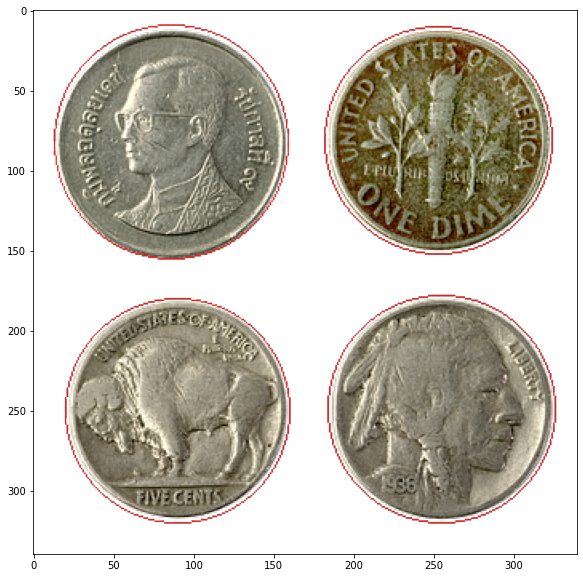

In [241]:
# reading coins image
coins = imread("imgs/coins.png",True)
# search space
hough_radii = np.arange(0, 100, 1)
# finding hough circle
cx, cy, radii = find_hough_circle(coins,hough_radii,top=100)
# selecting top 4
top4 = radii.argsort()[-4:][::-1]
# drawing circle boundries
for center_y, center_x, radius in zip(cy[top4], cx[top4], radii[top4]):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=coins.shape)
    coins[circy, circx] = (255, 20, 20,255)
# plotting
plt.imshow(coins, cmap=plt.cm.gray)
plt.gcf().set_size_inches((10,10))

## Active Contour Model

The active contour model is a method to fit open or closed splines to lines or edges in an image. It works by **minimizing an energy that is in part defined by the image and part by the spline’s shape: length and smoothness.** The minimization is done implicitly in the shape energy and explicitly in the image energy.



In [342]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

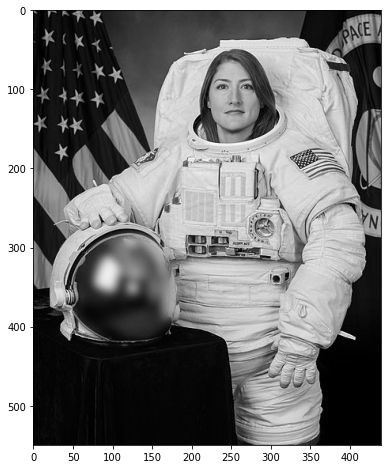

In [364]:
# loading christina image
christina = gray(imread("imgs/christina.jpg",True))
plt.imshow(christina,cmap="gray")
plt.gcf().set_size_inches((8,8))

In [365]:
# creating initial circle
s = np.linspace(0, 2*np.pi, 400)
x = 250 + 65*np.cos(s)
y = 115 + 65*np.sin(s)
init = np.array([x, y]).T

# finding active contour
cntr = active_contour(gaussian(christina, 3),init, alpha=0.015, beta=10, gamma=0.001)

<ipython-input-365-796a72a589d2>:8: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  cntr = active_contour(gaussian(christina, 3),init, alpha=0.015, beta=10, gamma=0.001)


(0.0, 440.0, 550.0, 0.0)

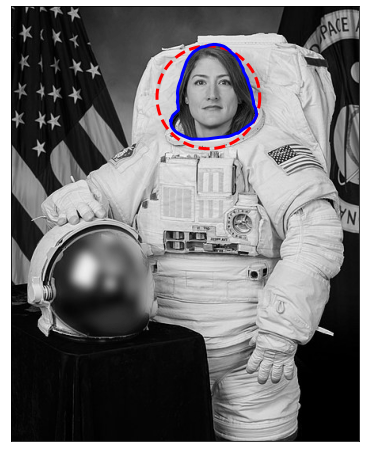

In [366]:
# plotting
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(christina, cmap=plt.cm.gray)
# Circular boundary
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
# countour
ax.plot(cntr[:, 0], cntr[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, christina.shape[1], christina.shape[0], 0])

## Visual Features

### Image Point Matching Problem

- Suppose I have two images related by some transformation Or have two images of the same object in different positions.
- How to find the transformation of image 1 that would align it with image 2


<br />
<figure>
  <img src="imgs/transformation.png" />
  <center><figcaption>Fig.1(a): Transformation</figcaption></center>
</figure>

#### We want Local$ ^{(1)}$ Features$ ^{(2)}$

*Not machine learning features, but things that we compute about little region or spots*

- Goal: Find point in an image that can be:
    - Found in other images
    - Found precisely - well localized
    - Found reliably - well matched
    
Why?

- Want to compute a fundamental matrix to recover geometry
- Robotics/vision: See how a bunch of points move from one frame to another. Allows computation of how camera moved -> depth -> moving objects
- Build a panorama


<br />
<figure>
  <img src="imgs/building_panorama.gif" />
  <center><figcaption>Fig.1(b): Building panorama</figcaption></center>
</figure>


### Matching with Features

- Detect features (features points) in both images
- Match features - find corresponding pairs
- Use these pairs to align images

<br />
<figure>
  <img src="imgs/detecting_points.png" />
  <center><figcaption>Fig.2(a): Similar Points</figcaption></center>
</figure>
<figure>
  <img src="imgs/detecting_points2.png" />
  <center><figcaption>Fig.2(b): Result</figcaption></center>
</figure>

- Problem 1:
    - Detec the same point independently in both
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (c): No chance to match</figcaption></center>
</figure>

<center><font color="green">We need a repeatable detector</font></center>


- Problem 2:
    - For each point correctly recognize the corresponding one
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (d): Which point is which</figcaption></center>
</figure>

<center><font color="green">We need a reliable and distinctive descriptor</font></center>


### More motivation...

- Feature points are used also for:
    - Image alignment (e.g. homography or fundamental matrix)
    - 3D reconstruction
    - Mortion tracking
    - Object recognition
    - Indexing and database retrieval
    - Robot navigation
    - ... Other

### Example Haris Corners

<br />
<figure>
  <img src="imgs/harris_corner.png" width=400 />
  <center><figcaption>Fig.4: Energy Equation </figcaption></center>
</figure>

In [26]:
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
import customized_orb
def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    if len(image.shape) > 2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap="gray")
    plt.gcf().set_size_inches((8,8))
    y, x = np.transpose(filtered_coords)
    plt.plot(x, y, 'r.')
    plt.axis('off')
    
def plot_matches_local(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False,
                 alignment='horizontal'):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1 = image1
    image2 = image2
    
    images = [image1,image2]
    widths, heights = zip(*((i.shape[0],i.shape[1]) for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    if len(image1.shape) > 2:
        image = np.zeros((total_width,max_height,image1.shape[-1])).astype(np.uint8)
    else:
        image = np.zeros((total_width,max_height)).astype(np.uint8)
        
    print(image1.shape,image2.shape,image.shape)
    
    image[:image1.shape[0],:image1.shape[1]] = image1
    image[image1.shape[0]:] = image2
    offset = np.array(image1.shape)
    
    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1], keypoints2[:, 0]+ offset[0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, cmap='gray')
    offset = np.array(image1.shape)
    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]+ offset[0]),
                '-', color=color)

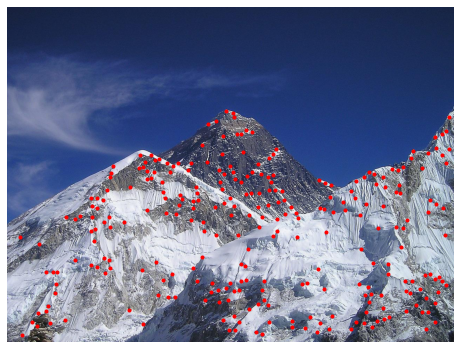

In [3]:
# reading hill image
hill = imread("imgs/hill.jpg",True)
# blur then gray
hill_gray = gray(blur(hill))
# finding harris corners
coords = corner_peaks(corner_harris(hill_gray), min_distance=10, threshold_rel=0.001)
# plot them
plot_harris_points(hill,coords)

#### feature matching using ORB which depends on harris corners

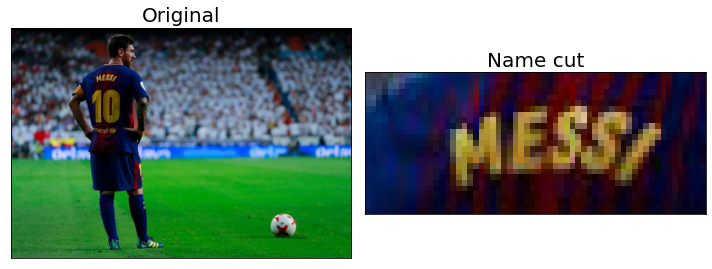

In [4]:
# loading messi
messi_f = imread("imgs/messi_foul.jpg",True)
messi_f_gray = gray(messi_f)
# extracting messin name
messi_name = messi_f[80:105,140:200]
messi_name_gray = messi_f_gray[80:105,140:200]
plot_grid([messi_f,messi_name],["Original","Name cut"])

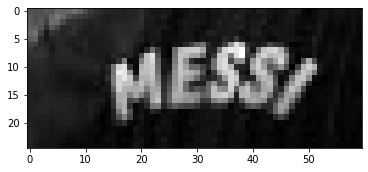

In [5]:
plt.imshow(messi_name_gray,cmap="gray")

In [36]:
# defining ORB
import importlib
importlib.reload(customized_orb)
messi_extractor = ORB(n_keypoints=50)
messi_name_extractor = customized_orb.CustomizedORB(n_keypoints=200,peak_distance=0,peak_threshold=0.01)

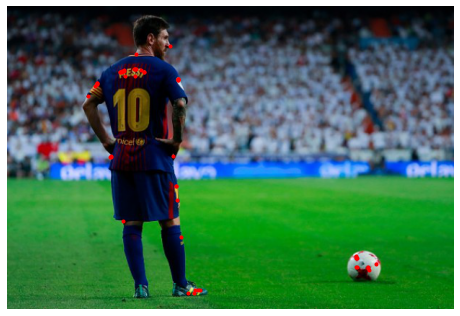

In [37]:
# extracting features from original image
messi_extractor.detect_and_extract(messi_f_gray)
keypoints1 = messi_extractor.keypoints
descriptors1 = messi_extractor.descriptors
plot_harris_points(messi_f,keypoints1)

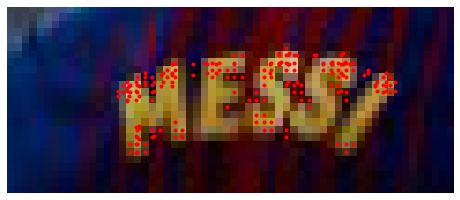

In [38]:
messi_name_extractor.detect_and_extract(messi_name_gray)
keypoints2 = messi_name_extractor.keypoints
descriptors2 = messi_name_extractor.descriptors
plot_harris_points(messi_name,keypoints2)

(25, 60, 3) (420, 620, 3) (445, 620, 3)


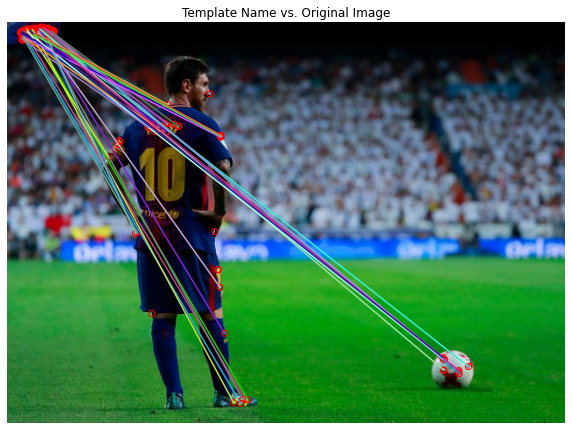

In [39]:
matches21 = match_descriptors(descriptors2,descriptors1, cross_check=True)
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches_local(ax, messi_name,messi_f,keypoints2,keypoints1, matches21,keypoints_color="red",alignment="vertical")
ax.axis('off')
ax.set_title("Template Name vs. Original Image")
fig.set_size_inches((10,10))

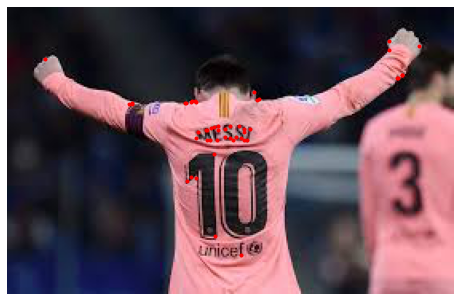

In [40]:
messi_e = imread("imgs/messi_espanyol.jpg",True)
messi_e_gray = gray(messi_e)
# extracting features from original image
messi_extractor.detect_and_extract(messi_e_gray)
keypoints1 = messi_extractor.keypoints
descriptors1 = messi_extractor.descriptors
plot_harris_points(messi_e,keypoints1)

(25, 60, 3) (180, 280, 3) (205, 280, 3)


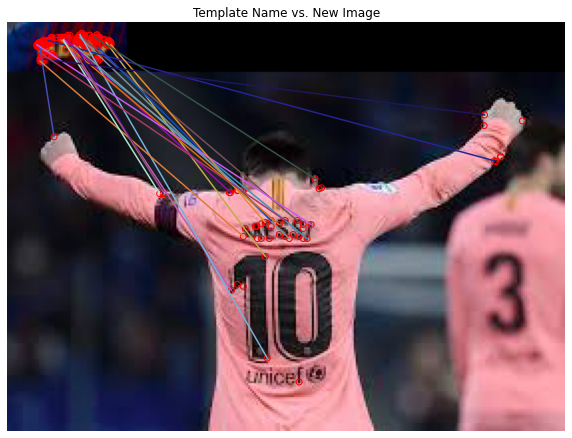

In [41]:
matches21 = match_descriptors(descriptors2,descriptors1, cross_check=True)
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches_local(ax, messi_name,messi_e,keypoints2,keypoints1, matches21,keypoints_color="red",alignment="vertical")
ax.axis('off')
ax.set_title("Template Name vs. New Image")
fig.set_size_inches((10,10))

### HAAR-LIKE Features

Haar-like features are simple digital image features that were introduced in a real-time face detector 1. These features can be efficiently computed on any scale in constant time, using an integral image 1. After that, a small number of critical features is selected from this large set of potential features (e.g., using AdaBoost learning algorithm as in 1). The following example will show the mechanism to build this family of descriptors.

In [42]:
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

#### Different types of Haar-like feature descriptors

The Haar-like feature descriptors come into 5 different types as illustrated in the figure below. The value of the descriptor is equal to the difference between the sum of intensity values in the green and the red one.

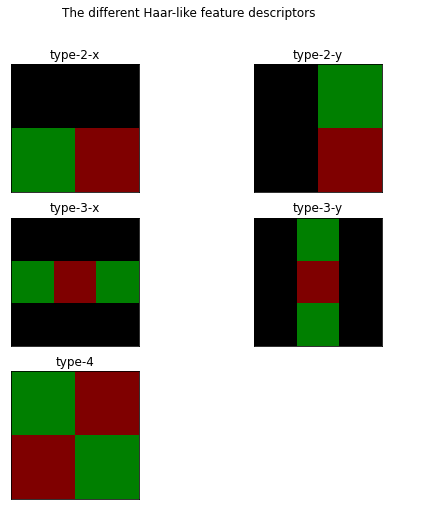

In [44]:
images = [np.zeros((2, 2)), np.zeros((2, 2)),
          np.zeros((3, 3)), np.zeros((3, 3)),
          np.zeros((2, 2))]

feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

fig, axs = plt.subplots(3, 2,figsize=(8,8))
for ax, img, feat_t in zip(np.ravel(axs), images, feature_types):
    coord, _ = haar_like_feature_coord(img.shape[0], img.shape[1], feat_t)
    haar_feature = draw_haar_like_feature(img, 0, 0,
                                          img.shape[0],
                                          img.shape[1],
                                          coord,
                                          max_n_features=1,
                                          random_state=0)
    ax.imshow(haar_feature)
    ax.set_title(feat_t)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The different Haar-like feature descriptors')
plt.axis('off')
plt.show()

The value of the descriptor is equal to the difference between the sum of the intensity values in the green rectangle and the red one. The red area is subtracted to the sum of the pixel intensities of the green In practice, the Haar-like features will be placed in all possible location of an image and a feature value will be computed for each of these locations.

In [47]:
from dask import delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [53]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [55]:
images = lfw_subset()
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)
# Compute the result
X = np.array(X.compute(scheduler='threads'))

# Label images (100 faces and 100 non-faces)
y = np.array([1] * 100 + [0] * 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

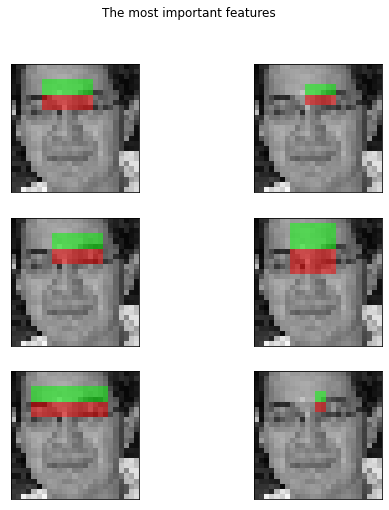

In [58]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2,figsize=(8,8))
for idx, ax in enumerate(axes.ravel()):
    image = images[10]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

The rest of the code can be found <a href="https://scikit-image.org/docs/dev/auto_examples/applications/plot_haar_extraction_selection_classification.html">here</a>

Also, check out the different cascade classifiers <a href="https://github.com/opencv/opencv/tree/master/data/haarcascades">available on opencv</a>

## Classical Machine Learning Methods

### Dimension reduction and visualization with PCA

In [120]:
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [121]:
def plot_dataset(dataset,nrows,ncols,figsize=(5,5)):
    """
    Receive a dataset and plot random subset of it in grid(nrows,ncols)
    """
    np.random.seed(1)
    j = 1
    fig = plt.figure(figsize=(figsize)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
    for i in np.random.choice(dataset.shape[0], nrows*ncols):
        plt.subplot(nrows,ncols,j)
        plt.imshow(dataset[i,:], cmap='binary')
        plt.axis('off')
        j += 1
    plt.show()

def plot_pca_2(datasets_pca,targets):
    plt.figure(figsize=(15,10))
    plt.scatter(datasets_pca[:, 0], datasets_pca[:, 1], lw=0.25, 
                c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    plt.xlabel('PC1', size=20)
    plt.ylabel('PC2', size=20)
    plt.title('2D Projection of handwritten digits with PCA', size=25)
    plt.colorbar(ticks=range(10), label='digit value')
    plt.clim(-0.5, 9.5)

def plot_pca_4(datasets_pca,targets,order=[0,1,2,3]):
    fig, ax = plt.subplots(ncols=2,figsize=(15,10))
    ax[0].scatter(datasets_pca[:, order[0]], datasets_pca[:, order[1]], lw=0.25, 
                c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    ax[0].set_xlabel(f'PCA {order[0]+1}', size=20)
    ax[0].set_ylabel(f'PCA {order[1]+1}', size=20)
    
    p1 = ax[1].scatter(datasets_pca[:, order[2]], datasets_pca[:, order[3]], lw=0.25, 
            c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    ax[1].set_xlabel(f'PCA {order[2]+1}', size=20)
    ax[1].set_ylabel(f'PCA {order[3]+1}', size=20)
    fig.colorbar(p1,ticks=range(10), label='')
    #plt.title('4D Projection of handwritten digits with PCA', size=25)
    
    #plt.clim(-0.5, 9.5)

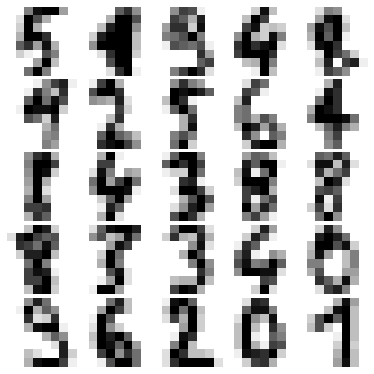

In [348]:
# load digits dataset
digits = load_digits()
# show random 25 subset
plot_dataset(digits.data.reshape((-1,8,8)),5,5)

0.2850936482369694


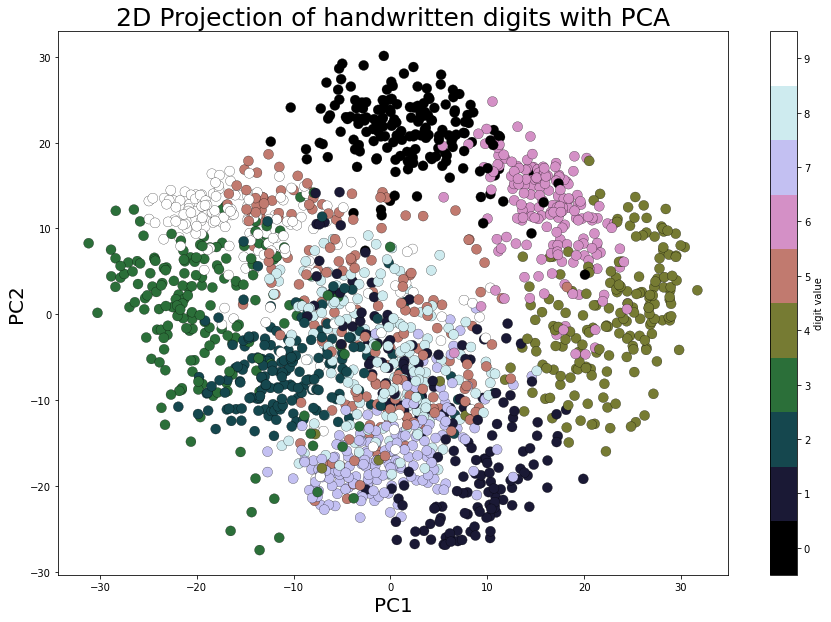

In [258]:
# creating PCA with 2 principles 
pca=PCA(2)
# transform the data with PCA
digits_pca = pca.fit_transform(digits.data) 
# print the principle variance ratio
print(np.sum(pca_digits.explained_variance_ratio_))
# plots the dataset as projected on 2 pcas
plot_pca_2(digits_pca,digits.target)

0.2850936482369694


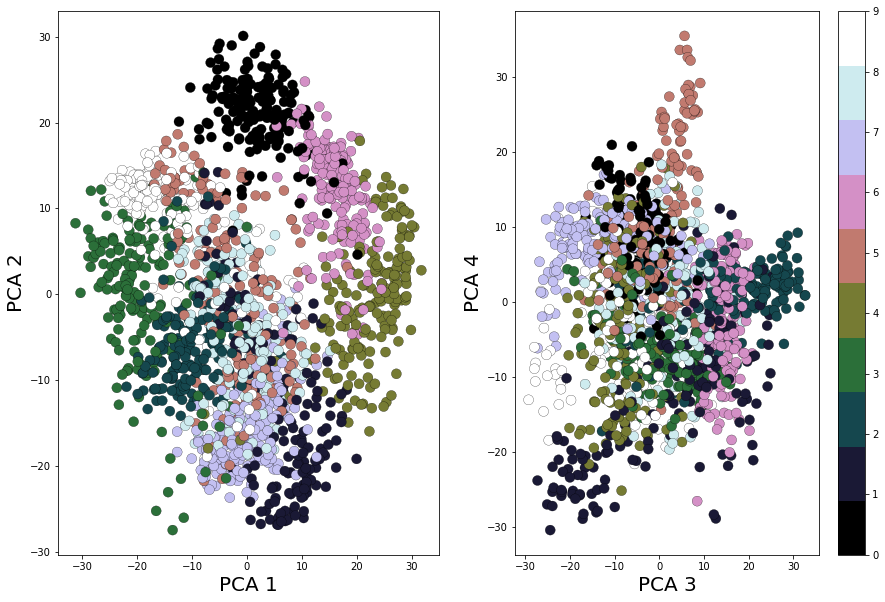

In [341]:
# creating PCA with 4 principles 
pca=PCA(4)
# transform the data with PCA
digits_pca = pca.fit_transform(digits.data) 
# print the principle variance ratio
print(np.sum(pca_digits.explained_variance_ratio_))
# plots the dataset as projected on 2 pcas
plot_pca_4(digits_pca,digits.target,[0,1,2,3])

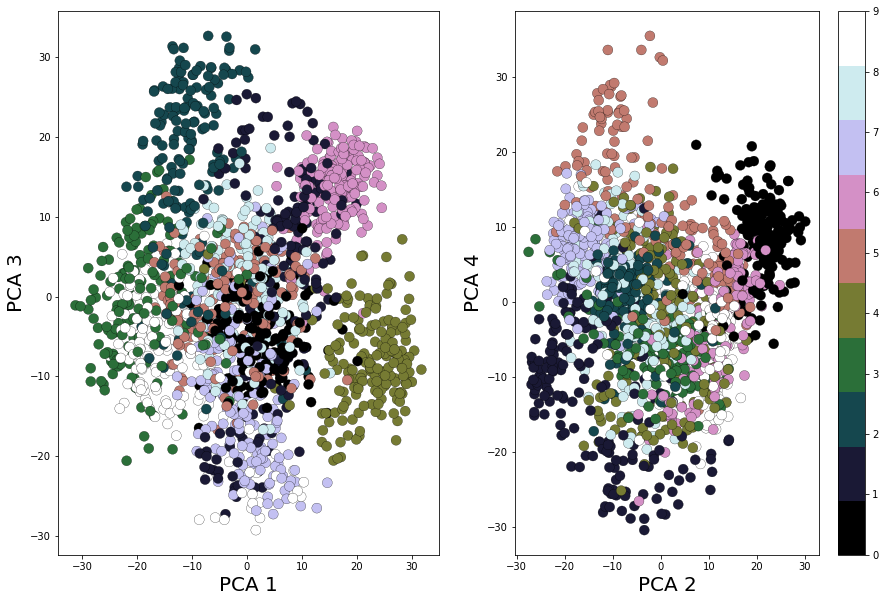

In [340]:
plot_pca_4(digits_pca,digits.target,[0,2,1,3])

<font color="red" size=5pt>checkout eigenfaces as well</font>

### K-Means segmentation with color quantization

In [333]:
from sklearn.cluster import KMeans 

def cluster_kmeans(img_vec,ncolors,nsamples=1000):
    """
    Receive vectorized image, number of colors, and 
        number of sample to train kmeans classifier
    Return labels vector for every element in the vectorized image and the classifier's centers
    """
    samples = img_vec[np.random.choice(img_vec.shape[0], nsamples, replace=False)]
    predictor = KMeans(n_clusters=ncolors, random_state=0).fit(samples)
    labels = predictor.predict(img_vec)
    centers = predictor.cluster_centers_
    return labels,centers

def segment(img,ncolors):
    """
    Receive an image and number of colors
    Return segmented image with n colors using kmeans
    """
    h,w,d = img.shape
    img_vec = img.reshape((-1,d))
    labels,centers = cluster_kmeans(img_vec,ncolors)
    segmented = np.array([centers[l] for l in labels])
    return segmented.reshape(img.shape).astype(np.uint8)

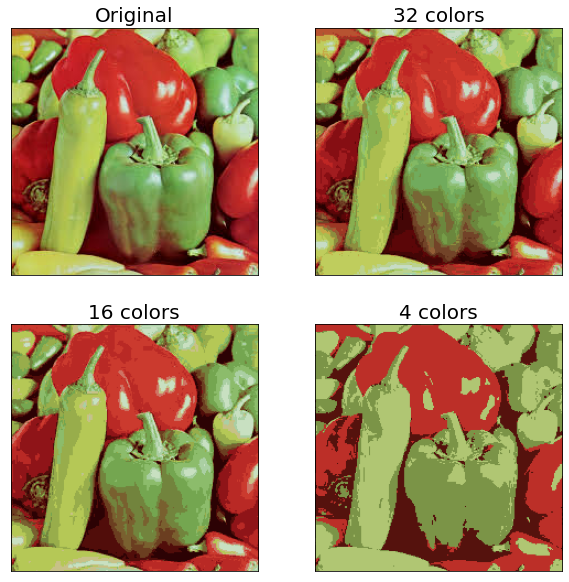

In [332]:
# reading peper image
pepper = imread("imgs/pepper.jpg",True)
# several colors choises
colors = [32,16,4]
# segmented images
segmented = [segment(pepper,c) for c in colors]
# plotting
plot_grid([pepper]+segmented[:3],["Original"]+[f"{c} colors" for c in colors[:3]])

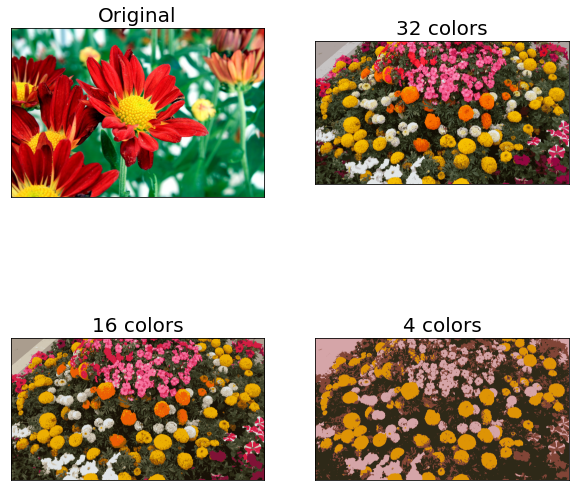

In [335]:
# reading flowers image
flowers = imread("imgs/flowers.png",True)
# several colors choises
colors = [32,16,4]
# segmented images
segmented = [segment(flowers,c) for c in colors]
# plotting
plot_grid([flowers]+segmented[:3],["Original"]+[f"{c} colors" for c in colors[:3]])

## Image Classification

In [4]:
## Needed imports
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.neighbors import BallTree
import seaborn as sn
from sklearn import metrics
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from keras.preprocessing import image                  
from tqdm import tqdm

In [254]:
def paths_to_vector(paths,target_size=(96,43)):
    """
    Read list of file paths into images with size @target_size, then vectorize them
    """
    images = []
    for f in paths:
        img = Image.open(f)
        img = img.resize(target_size,Image.ANTIALIAS)
        images.append(gray(np.asarray(img).copy()))
        img.close()
    images = np.array(images)
    return images.reshape((images.shape[0],-1))

def path_to_tensor(img_path,target_size,mode):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)

    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, d)
    imgarray = image.img_to_array(img)
    if mode == "gray":
        imgarray = gray(imgarray)
        w,h = imgarray.shape
        imgarray = np.repeat(imgarray,3).reshape((w,h,3))
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, d) and return 4D tensor
    return np.expand_dims(imgarray, axis=0)

def paths_to_tensor(img_paths,target_size,mode):
    list_of_tensors = [path_to_tensor(img_path,target_size,mode) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def get_encoders(key):
    """
    Return label encoders given tuple list [(name,number),(name,number)....]
    """
    binarizer = LabelBinarizer()
    binarizer.fit([k[1] for k in key])
    labeler = LabelEncoder()
    labeler.fit([k[0] for k in key])
    return binarizer,labeler

def load_dataset(path,mode="vector",target_size=(19,10)):
    """
    Load scikit-learn based image dataset given path, mode and target_size
    @mode: vector, gray, or color
    return data, and targets (integer values as read from images file names)
    """
    data = load_files(path)
    files = np.array(data['filenames'])
    targets= np.array(data["target"])
    #targets = binarizer.transform(np.array(data['target']))
    if mode=="vector":
        data = paths_to_vector(files,target_size)
    elif mode == "color_tensors":
        data = paths_to_tensor(files,target_size,"color")
    elif mode == "gray_tensors":
        data = paths_to_tensor(files,target_size,"gray")
    return data, targets

In [134]:
# Our dataset key
key = [["01.Marc-André ter Stegen",1],
       ["02.Gerard Piqué",2],
       ["03.Clément Lenglet",3],
       ["04.Jordi Alba",4],
       ["05.Sergi Roberto",5],
       ["06.Ivan Rakitic",6],
       ["07.Sergio Busquets",7],
       ["08.Coutinho",8],
       ["09.Arturo Vidal",9],
       ["10.Luis Suárez", 10],
       ["11.Lionel Messi",11]]
# our dataset encoders
binarizer,labeler = get_encoders(key)

In [135]:
# load train, test, and validation datasets in vector mode
target_size = (43,93)
train_data, train_targets = load_dataset('dataset/barcavslivercl/train',mode="vector", target_size=target_size)
valid_data, valid_targets = load_dataset('dataset/barcavslivercl/valid',mode="vector", target_size=target_size)
test_data, test_targets = load_dataset('dataset/barcavslivercl/test',mode="vector", target_size=target_size)

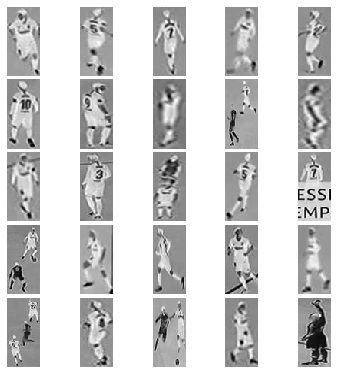

In [136]:
# plotting sample
rt = train_data.reshape((-1,target_size[1],target_size[0]))
plot_dataset(rt,5,5)

### Classifying with nearest neighbors

In [137]:
# combining train and valid
#train_data, train_targets = np.concatenate([train_data,valid_data],0),np.concatenate([train_targets,valid_targets])

In [138]:
# inverse transform from integer to names
train_labels = labeler.inverse_transform(train_targets)
test_labels = labeler.inverse_transform(test_targets)

In [139]:
## Build nearest neighbor structure on training data
ball_tree = BallTree(train_data)

In [140]:
## Get test data neighbors
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))

In [141]:
## Get predictions 
test_predictions = train_labels[test_neighbors]

Accuracy: 0.256


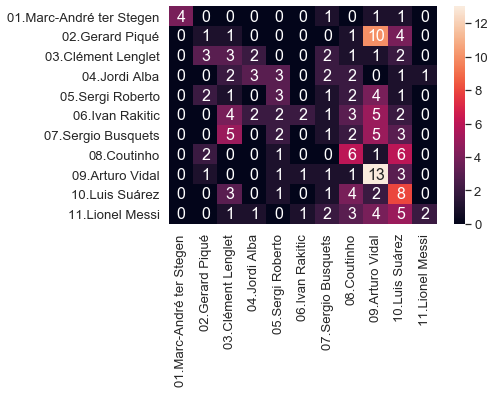

In [142]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,test_predictions)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

### Trrain with Naive Bayes

In [143]:
## creating gaussian naive bayes
gnb = GaussianNB()

In [144]:
## fitting the model on training data
gnb.fit(train_data, train_targets)

GaussianNB(priors=None, var_smoothing=1e-09)

In [145]:
# predicting
test_predictions = gnb.predict(test_data)
# converting numbers to names
prediction_labels = labeler.inverse_transform(test_predictions)

Accuracy: 0.344


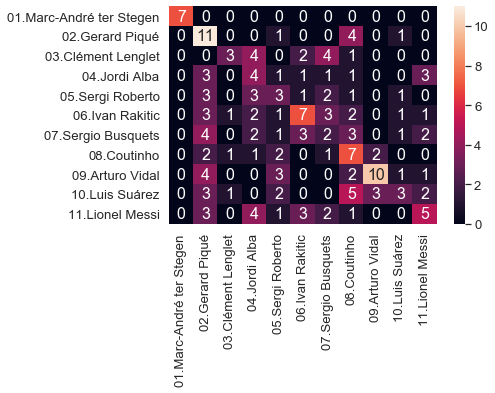

In [147]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,prediction_labels)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

### Classifying with SVM

In [148]:
## creating svm classifier with 
clf = SVC(C=2, kernel='poly', degree=2)

In [149]:
## fitting training data
clf.fit(train_data,train_targets)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [150]:
# predicting
test_predictions = clf.predict(test_data)
# converting numbers to names
prediction_labels = labeler.inverse_transform(test_predictions)

Accuracy: 0.406


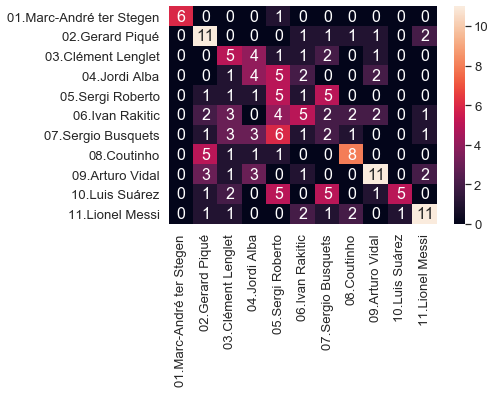

In [151]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,prediction_labels)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

## Deep Learning

In [267]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications import VGG16,VGG19,ResNet50
from keras.layers import Input,Flatten,Dense
import keras.backend as K
import keras.losses as losses
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
import os


def get_categorical_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

def add_flatten(x,target_size):
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    preds = Dense(target_size, activation='softmax')(x)
    return preds

def build_model(inp,output):
    model = Model(inputs=inp, outputs=output)
    model.compile(loss=losses.categorical_crossentropy, optimizer='adam', metrics=[get_categorical_accuracy_keras])
    return model

def _vgg19(input_size,target_size):
    inp = Input(shape=input_size)
    vgg_19 = VGG19(include_top=False, weights='imagenet', input_tensor=inp)
    x = vgg_19.output
    for layer in vgg_19.layers:
        layer.trainable = False 
    return build_model(vgg_19.inputs,add_flatten(x,target_size))

def _vgg16(input_size,target_size):
    inp = Input(shape=input_size)
    vgg_16 = VGG16(include_top=False, weights='imagenet', input_tensor=inp)
    x = vgg_16.output
    for layer in vgg_16.layers:
        layer.trainable = False 
    return build_model(vgg_16.inputs,add_flatten(x,target_size))
    
def input_branch(input_shape=None):
    size = int(input_shape[2] / 4)
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

    
def preprocess_Resnet50(tensors):
    preprocessed_input = preprocess_input_resnet50(tensors)
    return ResNet50(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)


def _resnet50(tr_tensors,val_tensors,input_size,output_size):
    
    train_resnet50 = preprocess_Resnet50(tr_tensors)
    valid_resnet50 = preprocess_Resnet50(val_tensors)
    
    resnet50_branch, resnet50_input = input_branch(input_shape=(2, 3, 2048))
    net = Dropout(0.1)(resnet50_branch)
    net = Dense(128, use_bias=False, kernel_initializer='uniform')(net)
    net = BatchNormalization()(net)
    net = Activation("relu")(net)
    net = Dropout(0.1)(net)
    net = Dense(output_size, kernel_initializer='uniform', activation="softmax")(net)
    model = Model(inputs=resnet50_input, outputs=[net])
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model,train_resnet50,valid_resnet50


def _train(model,train_data,valid_data,train_targets,valid_targets,checkPointFile,epochs=10):
    
    checkpointer = ModelCheckpoint(filepath=checkPointFile, 
                               verbose=1, save_best_only=True)
    model.fit(train_data, train_targets, 
          validation_data=(valid_data, valid_targets),
          epochs=epochs, batch_size=4, callbacks=[checkpointer], verbose=1)
    
def train(train_data,valid_data,train_targets,valid_targets,prioModel="vgg16"):
    checkpoint = None
    model = None
    input_size = list(train_data.shape)[1:]
    target_size = train_targets.shape[1]
    if prioModel == "vgg16":
        model = _vgg16(input_size,target_size)
        checkpoint = "models/vgg16.best.hdf5"
    elif prioModel == "vgg19":
        model = _vgg19(input_size,target_size)
        checkpoint = "models/vgg19.best.hdf5"
    elif prioModel == "resnet50":
        model,train_data,valid_data = _resnet50(train_data,valid_data,input_size,target_size)
        checkpoint = "models/resnet50.best.hdf5"
    if os.path.exists(checkpoint):
        os.remove(checkpoint)
    _train(model,train_data,valid_data,train_targets,valid_targets,checkpoint)
    return model

In [265]:
target_size = (43,93)
train_data, train_targets = load_dataset('dataset/barcavslivercl/train',mode="color_tensors", target_size=target_size)
valid_data, valid_targets = load_dataset('dataset/barcavslivercl/valid',mode="color_tensors", target_size=target_size)
test_data, test_targets = load_dataset('dataset/barcavslivercl/test',mode="color_tensors", target_size=target_size)


100%|██████████| 583/583 [00:00<00:00, 2800.65it/s]

100%|██████████| 184/184 [00:00<00:00, 2872.44it/s]

100%|██████████| 180/180 [00:00<00:00, 2838.98it/s]


In [157]:
# Our dataset key
key = [["01.Marc-André ter Stegen",1],
       ["02.Gerard Piqué",2],
       ["03.Clément Lenglet",3],
       ["04.Jordi Alba",4],
       ["05.Sergi Roberto",5],
       ["06.Ivan Rakitic",6],
       ["07.Sergio Busquets",7],
       ["08.Coutinho",8],
       ["09.Arturo Vidal",9],
       ["10.Luis Suárez", 10],
       ["11.Lionel Messi",11]]
binarizer,labeler = get_encoders(key)

In [199]:
# binarizing targets
train_targets_bin = binarizer.transform(train_targets+1)
valid_targets_bin = binarizer.transform(valid_targets+1)
test_targets_bin = binarizer.transform(test_targets+1)

In [207]:
vgg16Model = train(train_data,valid_data,train_targets_bin,valid_targets_bin)

In [201]:
vgg16Model.load_weights("models/vgg16.best.hdf5")

In [211]:
test_predictions_softmax = vgg16Model.predict(test_data)
test_predictions_integer = [np.argmax(prediction) for prediction in test_predictions_softmax]
# converting numbers to names
test_prediction_labels = labeler.inverse_transform(test_predictions_integer)
test_labels = labeler.inverse_transform(test_targets)

Accuracy: 0.233


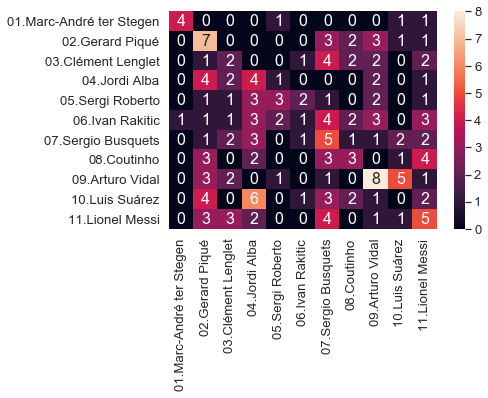

In [212]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,test_prediction_labels)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

In [208]:
vgg19Model = train(train_data,valid_data,train_targets_bin,valid_targets_bin,prioModel="vgg19")

Train on 583 samples, validate on 184 samples
Epoch 1/10
583/583 [==============================] - 42s 72ms/step - loss: 13.9656 - get_categorical_accuracy_keras: 0.1667 - val_loss: 7.3153 - val_get_categorical_accuracy_keras: 0.1576

Epoch 00001: val_loss improved from inf to 7.31531, saving model to models/vgg19.best.hdf5
Epoch 2/10
583/583 [==============================] - 41s 70ms/step - loss: 1.9793 - get_categorical_accuracy_keras: 0.5451 - val_loss: 5.4476 - val_get_categorical_accuracy_keras: 0.1957

Epoch 00002: val_loss improved from 7.31531 to 5.44763, saving model to models/vgg19.best.hdf5
Epoch 3/10
583/583 [==============================] - 40s 69ms/step - loss: 1.0677 - get_categorical_accuracy_keras: 0.7061 - val_loss: 4.9307 - val_get_categorical_accuracy_keras: 0.2174

Epoch 00003: val_loss improved from 5.44763 to 4.93067, saving model to models/vgg19.best.hdf5
Epoch 4/10
583/583 [==============================] - 40s 69ms/step - loss: 0.4819 - get_categorical_accu

In [209]:
vgg19Model.load_weights("models/vgg19.best.hdf5")

In [270]:
test_predictions_softmax = vgg19Model.predict(test_data)
test_predictions_integer = [np.argmax(prediction) for prediction in test_predictions_softmax]
# converting numbers to names
test_prediction_labels = labeler.inverse_transform(test_predictions_integer)
test_labels = labeler.inverse_transform(test_targets)

Accuracy: 0.194


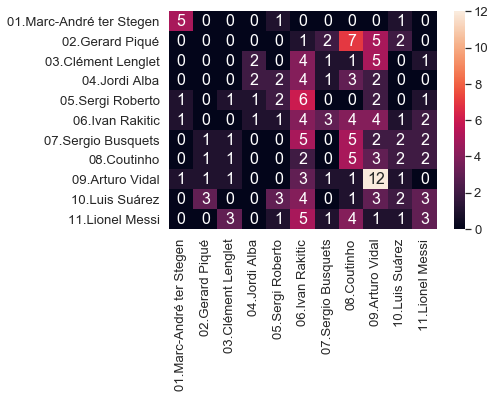

In [271]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,test_prediction_labels)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

In [268]:
resnet50 =  train(train_data,valid_data,train_targets_bin,valid_targets_bin,prioModel="resnet50")

Train on 583 samples, validate on 184 samples
Epoch 1/10
583/583 [==============================] - 7s 11ms/step - loss: 2.2972 - accuracy: 0.1492 - val_loss: 2.1797 - val_accuracy: 0.2011

Epoch 00001: val_loss improved from inf to 2.17972, saving model to models/resnet50.best.hdf5
Epoch 2/10
583/583 [==============================] - 3s 6ms/step - loss: 2.1616 - accuracy: 0.2401 - val_loss: 2.1091 - val_accuracy: 0.3207

Epoch 00002: val_loss improved from 2.17972 to 2.10910, saving model to models/resnet50.best.hdf5
Epoch 3/10
583/583 [==============================] - 4s 7ms/step - loss: 2.0440 - accuracy: 0.2847 - val_loss: 2.0410 - val_accuracy: 0.2989

Epoch 00003: val_loss improved from 2.10910 to 2.04103, saving model to models/resnet50.best.hdf5
Epoch 4/10
583/583 [==============================] - 4s 7ms/step - loss: 1.9300 - accuracy: 0.3345 - val_loss: 1.9728 - val_accuracy: 0.3370

Epoch 00004: val_loss improved from 2.04103 to 1.97275, saving model to models/resnet50.bes

In [269]:
resnet50.load_weights("models/resnet50.best.hdf5")

In [273]:
resenet50_tensors = preprocess_Resnet50(test_data)
test_predictions_softmax = resnet50.predict(resenet50_tensors)
test_predictions_integer = [np.argmax(prediction) for prediction in test_predictions_softmax]
# converting numbers to names
test_prediction_labels = labeler.inverse_transform(test_predictions_integer)
test_labels = labeler.inverse_transform(test_targets)

/Users/jalalirs/opt/miniconda3/envs/bootcamp/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Accuracy: 0.206


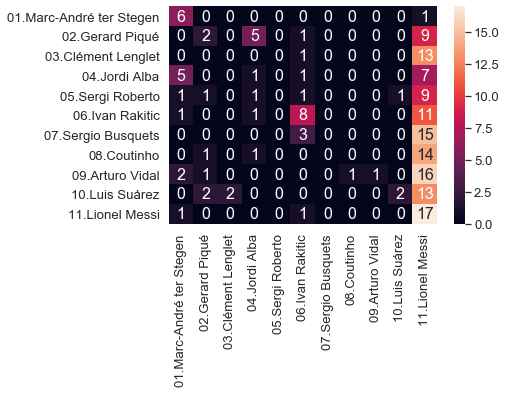

In [274]:
# creating confusion matrix
cm = metrics.confusion_matrix(test_labels,test_prediction_labels)
## print accuracy
print("Accuracy: %.03f" % (np.trace(cm)/cm.sum()))
# for better visualization we use seaborn along with pandas
# getting rows and columns as player names from the key above
names = [k[0] for k in key] 
# define dataframe from confusion matrix and set both column index and row index as player names
df_cm = pd.DataFrame(cm, names , names)
# plot confusion using seaborn
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")